Using code from Claire:

In [105]:
import numpy as np
from model import Environment, Agent
from display import plot_regret

from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [106]:
def play(environment, agent, Nmc, T):
    """
    Play one Nmc trajectories over a horizon T for the specified agent. 
    Return the agent's name (sring) and the collected data in an nd-array.
    """
    
    data = np.zeros((Nmc, T))
    
    for n in range(Nmc):
        agent.reset()
        #action_set = environment.get_action_set()
        for t in range(T):
            action = agent.get_action() 
            # Note that the main difference with the previous lab is that now get_action needs to receive the action_set
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)
            # compute instant regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive
            
    return agent.name(), data


def experiment(environment, agents, Nmc, T):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """
    
    all_data = {}
    
    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T)
        
        all_data[agent_id] = regrets
        
    return all_data

In [107]:
def randomActionsGenerator(K,d, mean=None):
    return np.diag(np.full(d,1)) #vecs / norms[:,np.newaxis]

In [108]:
class IID_env(Environment):
    
    def __init__(self, theta, K):
        """
        theta: d-dimensional vector (bounded) representing the hidden parameter
        K: number of actions per round (random action vectors generated each time)
        """
        self.d = np.size(theta)
        self.theta = theta
        self.K = K

            
        
    def get_reward(self, action):
    
        """ sample reward given action 
        """

        return np.random.normal(self.theta[action])
            
    def get_means(self):
        return  self.theta

 # Environment Class

The environment class allows to create 3 types of linear bandit problems: 
* 'fixed' : normally requires a fixed_actions input (otherwise randomly generated at start) which is kept all along the game;
* 'arbitrary': at each round, an 'arbitrary' set of actions is chosen and here we decided to simply create a pool of (d x K) vectors and let the environment choose K of them without replacement at each round;
* 'iid' : at each round, the environment samples K actions at random on the sphere.

For each of these types of game, the class is used to generate the action sets at each round and the reward for a chosen action (chosen by an Agent, see the "Play!" section for the details of the interaction).

In [109]:
class EpsilonGreedy(Agent):
  def __init__(self, d, eps=0.1):
    self.eps = eps # exploration probability
    self.d = d
    self.reset()
    
    self.cumulative_reward = np.zeros(self.d)
    self.num_played = np.zeros(self.d)
    self.hat_theta = np.zeros(self.d)

    
  def reset(self):
    self.t = 0
    self.hat_theta = np.zeros(self.d)


  def get_action(self):
    
    u = np.random.random()
    if u<self.eps:
        return np.random.choice(self.d)
    else:
        chosen_arm_index = np.argmax(self.hat_theta)
        return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """

    self.cumulative_reward[chosen_arm] += reward # update
    self.num_played[chosen_arm] += 1
    self.hat_theta[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm] # update

    self.t += 1   
        

  #@staticmethod
  def name(self):
    return 'EGreedy('+str(self.eps)+')'

In [110]:
d = 3  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized :
# theta = randomActionsGenerator(1,d)
theta = np.array([0.1, 0.3, 0.9])

T = 1000  # Horizon
N = 50  # Monte Carlo simulations

delta = 0.05 # could be set directly in the algorithms

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of percentile display
q = 10

In [111]:
iid_env = IID_env(theta, d) 
e_greedy = EpsilonGreedy(d,  eps=0.1)

/Users/julia/Downloads/practice_bandits/display.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


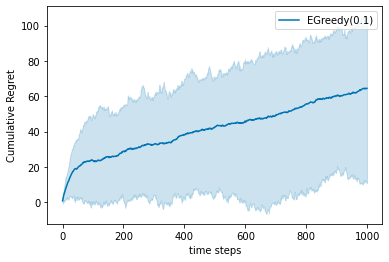

In [112]:
e_greedy_experiment = experiment(iid_env, [e_greedy], Nmc=N, T=T)
plot_regret(e_greedy_experiment, q=10)